## Numeryczne Rozwiązywanie Rónań Różniczkowych Cząstkowych
### Uniwersytet Jagielloński 2021
Katedra Teorii Optymalizacji i Sterowania UJ


# Metoda elementów skończonych

## Projekt

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import optimesh
import pygmsh
import meshio
import gmsh

% matplotlib inline

UsageError: Line magic function `%` not found.


In [4]:
geom = pygmsh.geo.Geometry()

mesh_size = 0.5
geom = pygmsh.occ.Geometry()
model3D = geom.__enter__()

print("creating box & cylinder")
box = model3D.add_box(x0=[0, 0, 0], extents=[1.2, 0.6, 0.6], mesh_size=mesh_size)
cylinder = model3D.add_cylinder(x0=[0.6, 0, 0], axis=[0, 0.6, 0], radius=0.3, mesh_size=mesh_size)

print("creating screws")
screws_locations = [[0.15, 0, 0.15], [1.05, 0, 0.15], [0.15, 0, 0.45], [1.05, 0, 0.45]]
screws = map(lambda x: model3D.add_cylinder(x0=x, axis=[0, 0.6, 0], radius=0.05, mesh_size=mesh_size), screws_locations)
for i, screw in enumerate(screws):
    box_minus_screw = model3D.boolean_difference(box, screw)
    model3D.add_physical(box_minus_screw, f"box minus screw_{i}")

box_minus_cylinder = model3D.boolean_difference(box, cylinder)
model3D.add_physical(box_minus_cylinder, "box minus cylinder")
model3D.synchronize()

print("generating mesh")
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", mesh_size)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", mesh_size)
mesh = geom.generate_mesh(dim=3)
import time

t = time.localtime()
current_time = time.strftime("%H-%M-%S", t)
print("writing mesh")
gmsh.write(f"mesh_{mesh_size.__str__().replace('.', '')}_{current_time}.vtk")
model3D.__exit__()
print("done")


creating box & cylinder
creating screws
generating mesh


/usr/local/lib/python3.9/site-packages/pygmsh/occ/geometry.py:221: UserWarning: Specified mesh size for <pygmsh.occ.box.Box object at 0x114fe9250> discarded in Boolean difference operation.
  warnings.warn(


writing mesh
done


In [16]:
vtk_file = "mesh_05_20-19-16.vtk"
mesh3D_from_msh = meshio.read(vtk_file)
print(mesh3D_from_msh)
print(mesh3D_from_msh.points, mesh3D_from_msh.points.shape)
print(mesh3D_from_msh.cells)
print(mesh3D_from_msh.point_data)
print(mesh3D_from_msh.cell_data)
print(mesh3D_from_msh.field_data)
print(mesh3D_from_msh.point_sets)
print(mesh3D_from_msh.cell_sets)
print(mesh3D_from_msh.gmsh_periodic)
print(mesh3D_from_msh.info)


<meshio mesh object>
  Number of points: 678
  Number of cells:
    tetra: 2098
  Cell data: CellEntityIds
[[0.         0.         0.6       ]
 [0.         0.         0.        ]
 [0.         0.6        0.6       ]
 ...
 [0.33814974 0.29096915 0.42645738]
 [1.05124441 0.50948999 0.36335984]
 [1.07433398 0.56748852 0.3713988 ]] (678, 3)
[<meshio CellBlock, type: tetra, num cells: 2098, tags: []>]
{}
{'CellEntityIds': [array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)]}
{}
{}
{}
None
None


In [3]:
from vtk import (vtkUnstructuredGridReader, vtkDataSetMapper, vtkActor,
                 vtkRenderer, vtkRenderWindow, vtkRenderWindowInteractor)
from vtkmodules.vtkCommonColor import vtkNamedColors

vtk_file = "mesh_05_20-19-16.vtk"

# Read the source file.
reader = vtkUnstructuredGridReader()
reader.SetFileName(vtk_file)
reader.Update()  # Needed because of GetScalarRange
output = reader.GetOutput()
output_port = reader.GetOutputPort()
scalar_range = output.GetScalarRange()

# Create the mapper that corresponds the objects of the vtk file
# into graphics elements
mapper = vtkDataSetMapper()
mapper.SetInputConnection(output_port)
mapper.SetScalarRange(scalar_range)

# Create the Actor
actor = vtkActor()
colors = vtkNamedColors()
actor.SetMapper(mapper)
actor.GetProperty().SetColor(colors.GetColor3d("#3344AA"))
actor.RotateX(-90.0)
actor.RotateY(0.0)

# Create the Renderer
renderer = vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1, 1, 1)  # Set background to white

# Create the RendererWindow
renderer_window = vtkRenderWindow()
renderer_window.AddRenderer(renderer)
renderer_window.SetSize(1920, 1080)
renderer_window.SetWindowName('Bridge')

# Create the RendererWindowInteractor and display the vtk_file
interactor = vtkRenderWindowInteractor()
interactor.SetRenderWindow(renderer_window)
interactor.Initialize()
interactor.Start()

In [17]:
def point_in_cylinder(pt1, pt2, r, q):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    q = np.array(q)
    vec = pt2 - pt1
    const = r * np.linalg.norm(vec)
    return np.where(np.dot(q - pt1, vec) >= 0 and np.dot(q - pt2, vec) <= 0
                    and np.linalg.norm(np.cross(q - pt1, vec)) <= const)


def forces(a, b, F):
    Y = np.sin(a) * F
    X = np.cos(a) * F
    return -X, -Y, 0  # todo: 3d vector here


class Setup:
    def __init__(self):

        self.nodes = np.array(mesh3D_from_msh.points)

        self.material_properties = np.array([2000, 0.25])

        # Dirichlet BC
        screws = [(0.15, 0, 0.15), (0.15, 0, 0.45)]  #, (1.05, 0, 0.15), (1.05, 0, 0.45)]
        dirichlet_predicate = lambda x, y, z: any(
            point_in_cylinder([a, b, c], [a, b + 0.6, c], 0.15, [x, y, z]) for (a, b, c) in screws)
        predicates = [
            dirichlet_predicate,
            dirichlet_predicate,
            dirichlet_predicate
        ]

        dirichlet = Setup.dirichlet(predicates, self.nodes)
        self.dirichlet = np.array(dirichlet)

        # Neumann BC
        predicates = [
            lambda x, y, z: z == 0.6,
            lambda x, y, z: z == 0.6,
            lambda x, y, z: z == 0.6
        ]

        alpha = np.pi / 4
        beta = 0

        values = [
            lambda x, y, z: forces(alpha, beta, x)[0],
            lambda x, y, z: forces(alpha, beta, x)[1],
            lambda x, y, z: forces(alpha, beta, x)[2]
        ]
        neumann = Setup.neumann(predicates, values, self.nodes)
        self.neumann = np.array(neumann)

        # internal forces
        self.force = np.array([0.0, -0.2, 0])

        # material properties
        self.young_modulus = 2000
        self.poisson_ratio = 0.25

    @staticmethod
    def dirichlet(predicates, nodes):
        dirichlet = []
        for (i, v) in enumerate(nodes):
            x, y, z = v
            for dir, p in enumerate(predicates):
                if p(x, y, z):
                    dirichlet += [[i, dir, 0]]
        return dirichlet

    @staticmethod
    def neumann(predicates, values, nodes):
        neumann = []
        for (i, v) in enumerate(nodes):
            x, y, z = v
            for dir, p in enumerate(predicates):
                if p(x, y, z):
                    neumann += [[i, dir, values[dir](x, y, z)]]
        return neumann


setup = Setup()

Constants

In [18]:
DIMENSION = 3
NODES_PER_ELEMENT = 3


Equation indecces mapping

In [19]:
global_size = DIMENSION * len(setup.nodes)
ID = np.arange(global_size).reshape(-1, DIMENSION)

Finite Element class

In [15]:

class FiniteElement:
    size = NODES_PER_ELEMENT * DIMENSION

    def __init__(self, e, setup):
        self.setup = setup

        # Calculate element element_eq_ids and coordinates 
        # element_eq_ids has the equations associated to element e
        self.eq_ids = np.zeros(FiniteElement.size)
        self.coord = np.zeros((NODES_PER_ELEMENT, DIMENSION))

        z = 0
        for j in range(NODES_PER_ELEMENT):
            J = setup.elements[e, j]  # global node of element
            for direction in range(DIMENSION):
                self.eq_ids[z] = ID[J, direction]
                z += 1

            self.coord[j] = setup.nodes[J]

        self.B, self.D, self.volume = self.make_B_and_D_matrices_and_volume()
        self.K, self.F = self.make_stiffness_matrix()

    def make_B_and_D_matrices_and_volume(self):
        x = 0; y = 1; z = 2
        a = 0; b = 1; c = 2; d = 3
        ex = self.setup.young_modulus
        nu = self.setup.poisson_ratio

        coord = self.coord

        subscripts = [
            (0, 1, 2, 3),
            (1, 2, 3, 0),
            (2, 3, 0, 1),
            (3, 0, 1, 2),
        ]

        abcd = np.matrix([
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0]
        ])

        for (i, j, k, l) in subscripts:
            abcd[a][i] = np.linalg.det([
                [coord[j, x], coord[j, y], coord[j, z]],
                [coord[k, x], coord[k, y], coord[k, z]],
                [coord[l, x], coord[l, y], coord[l, z]]
            ])
            abcd[b][i] = np.linalg.det([
                [1, coord[j, y], coord[j, z]],
                [1, coord[k, y], coord[k, z]],
                [1, coord[l, y], coord[l, z]]
            ])
            abcd[c][i] = np.linalg.det([
                [coord[j, y], 1, coord[j, z]],
                [coord[k, y], 1, coord[k, z]],
                [coord[l, y], 1, coord[l, z]]
            ])
            abcd[d][i] = np.linalg.det([
                [coord[j, y], coord[j, z], 1],
                [coord[k, y], coord[k, z], 1],
                [coord[l, y], coord[l, z], 1]
            ])

        V = (1/6) * np.linalg.det([
            [1, coord[0, x], coord[0, y], coord[0, z]],
            [1, coord[1, x], coord[1, y], coord[1, z]],
            [1, coord[2, x], coord[2, y], coord[2, z]],
            [1, coord[3, x], coord[3, y], coord[3, z]]
        ])

        B = (1 / (2 * V)) * np.matrix([
            [abcd[b][0], 0, 0, abcd[b][1], 0, 0, abcd[b][2], 0, 0, abcd[b][3], 0, 0],
            [0, abcd[c][0], 0, 0, abcd[c][1], 0, 0, abcd[c][2], 0, 0, abcd[c][3], 0],
            [0, 0, abcd[d][0], 0, 0, abcd[d][1], 0, 0, abcd[d][2], 0, 0, abcd[d][3]],
            [abcd[c][0], abcd[b][0], 0, abcd[c][1], abcd[b][1], 0, abcd[c][2], abcd[b][2], 0, abcd[c][3], abcd[b][3], 0],
            [0, abcd[d][0], abcd[c][0], 0, abcd[d][1], abcd[c][1], 0, abcd[d][2], abcd[c][2], 0, abcd[d][3], abcd[c][3]],
            [abcd[d][0], 0, abcd[b][0], abcd[d][1], 0, abcd[b][1], abcd[d][2], 0, abcd[b][2], abcd[d][3], 0, abcd[b][3]],
        ])

        D = ex / ((1 + nu) * (1 - 2 * nu)) * np.matrix([
            [1 - nu, nu, nu, 0, 0, 0],
            [nu, 1 - nu, nu, 0, 0, 0],
            [nu, nu, nu - 1, 0, 0, 0],
            [0, 0, 0, (1 - 2 * nu) / 2, 0, 0],
            [0, 0, 0, 0, (1 - 2 * nu) / 2, 0],
            [0, 0, 0, 0, 0, (1 - 2 * nu) / 2]
        ])

        return B, D, V

    def make_stiffness_matrix(self):
        Ke = self.B.T * self.D * self.B * self.volume

        Fe1 = (self.volume * self.setup.force[0] * np.array([
            1/6, 0.0, 0.0,
            1/6, 0.0, 0.0,
            1/6, 0.0, 0.0,
            1/6, 0.0, 0.0,
            1/6, 0.0, 0.0,
            1/6, 0.0, 0.0
        ]))  # x mask

        Fe2 = (self.volume * self.setup.force[1] * np.array([
            0.0, 1/6, 0.0,
            0.0, 1/6, 0.0,
            0.0, 1/6, 0.0,
            0.0, 1/6, 0.0,
            0.0, 1/6, 0.0,
            0.0, 1/6, 0.0
        ]))  # y mask

        Fe3 = (self.volume * self.setup.force[2] * np.array([
            0.0, 0.0, 1/6,
            0.0, 0.0, 1/6,
            0.0, 0.0, 1/6,
            0.0, 0.0, 1/6,
            0.0, 0.0, 1/6,
            0.0, 0.0, 1/6
        ]))  # z mask

        Fe = Fe1 + Fe2 + Fe3

        return Ke, Fe

Building equation system

In [12]:
K = np.zeros((global_size, global_size))
F = np.zeros((global_size, 1))

for e in range(len(setup.elements)):
    element = FiniteElement(e, setup)

    for i in range(FiniteElement.size):
        I = int(element.eq_ids[i])
        for j in range(FiniteElement.size):
            J = int(element.eq_ids[j])
            # Adds element matrix K to global matrix K
            K[I, J] += element.K[i, j]
        # Adds load element vector F in F
        F[I] += element.F[i]

Neumann Boundary Condition

In [19]:
for node, dof, value in setup.neumann:
    i = ID[int(node), int(dof)]  # >_<

    # we want to increase force on the
    F[i] += value

Dirichlet Boundary Condition

In [14]:
for node, direction, value in setup.dirichlet:
    i = ID[int(node), int(direction)]  # >_<
    F[:, 0] = F[:, 0] - value * K[:, i]

    # we want to remove one equation
    K[i, :] = 0.0
    K[:, i] = 0.0
    K[i, i] = 1.0
    F[i] = value

Solving

In [20]:
displacement = np.linalg.solve(K, F).reshape(len(setup.nodes), DIMENSION)


In [33]:
# for vizualization
FACTOR = 0.1

displaced_nodes = setup.nodes + FACTOR * displacement


Plotting

In [17]:
def view_mesh(nodes, elements, label, node_color='r', edge_color='k'):
    graph = nx.Graph()
    for i, j, k in elements:
        graph.add_edge(i, j)
        graph.add_edge(i, k)
        graph.add_edge(j, k)

    node_size = 20 + (1000 / len(setup.nodes))

    nx.draw(graph, pos=nodes, label=label, node_color=node_color,
            edge_color=edge_color, node_size=node_size)

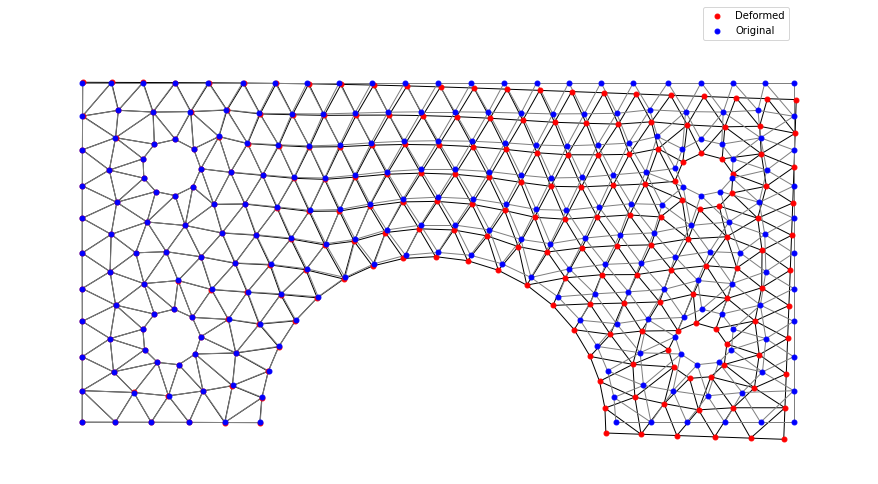

In [34]:
f = plt.figure()
view_mesh(displaced_nodes, setup.elements, label='Deformed')
view_mesh(setup.nodes, setup.elements, label='Original',
          node_color='b', edge_color='0.5')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles=[handles[0], handles[2]], bbox_to_anchor=(0.8, 1),
           bbox_transform=plt.gcf().transFigure)

f.set_size_inches(12, 6)
plt.show()

Stress

In [35]:
def StressT3_EPT(element, UEl, s):
    StressE = element.D * element.B * UEl.T

    # Create 2D stress matrix
    S = np.zeros((DIMENSION, DIMENSION))
    S[0, 0] = StressE[0]
    S[1, 1] = StressE[1]
    S[1, 0] = S[0, 1] = StressE[2]

    # Stress in z direction is ZERO under plane stress conditions
    StressE = np.append(StressE, [[0]], axis=0)

    # Calculate principal stresses by finding the eigenvalues of S 
    w, v = np.linalg.eig(S)
    s1, s2 = w

    # Von Mises Stress
    SVME = np.sqrt(s1 ** 2 - s1 * s2 + s2 ** 2)

    # Tresca Stress
    STRE = 0.5 * np.abs(s1 - s2)

    return StressE, SVME, STRE

In [37]:
count = np.zeros(len(setup.nodes))
Sx = np.zeros(len(setup.nodes))
Sy = np.zeros(len(setup.nodes))
Sxy = np.zeros(len(setup.nodes))
Sz = np.zeros(len(setup.nodes))
SVM = np.zeros(len(setup.nodes))
STR = np.zeros(len(setup.nodes))

for e in range(len(setup.elements)):
    element = FiniteElement(e, setup)
    UEl = np.zeros(FiniteElement.size)

    z = 0
    for j in range(NODES_PER_ELEMENT):
        J = setup.elements[e, j]
        for i in range(DIMENSION):
            UEl[z] = displacement[J, i]
            z += 1

    # Calls method that calculates element
    # stress StressE, von Mises stress SVME
    # and Tresca stress STRE
    StressE, SVME, STRE = StressT3_EPT(
        element,
        np.matrix(UEl),
        setup
    )

    i, j, k = setup.elements[e]

    Sx[i] = Sx[i] + StressE[0]
    Sx[j] = Sx[j] + StressE[0]
    Sx[k] = Sx[k] + StressE[0]

    Sy[i] = Sy[i] + StressE[1]
    Sy[j] = Sy[j] + StressE[1]
    Sy[k] = Sy[k] + StressE[1]

    Sxy[i] = Sxy[i] + StressE[2]
    Sxy[j] = Sxy[j] + StressE[2]
    Sxy[k] = Sxy[k] + StressE[2]

    Sz[i] = Sz[i] + StressE[3]
    Sz[j] = Sz[j] + StressE[3]
    Sz[k] = Sz[k] + StressE[3]

    SVM[i] = SVM[i] + SVME
    SVM[j] = SVM[j] + SVME
    SVM[k] = SVM[k] + SVME

    STR[i] = STR[i] + STRE
    STR[j] = STR[j] + STRE
    STR[k] = STR[k] + STRE

    count[i] += 1
    count[j] += 1
    count[k] += 1

# Divide by counters
for i in range(len(setup.nodes)):
    Sx[i] = Sx[i] / count[i]
    Sy[i] = Sy[i] / count[i]
    Sxy[i] = Sxy[i] / count[i]
    Sz[i] = Sz[i] / count[i]
    SVM[i] = SVM[i] / count[i]
    STR[i] = STR[i] / count[i]

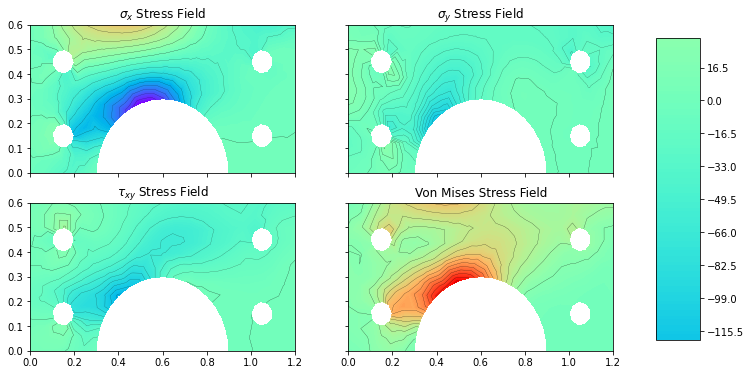

In [38]:
# Only works for the LARGE CASE
x = setup.nodes[:, 0]
y = setup.nodes[:, 1]

# Choose with stress you want to vizualize: 
# Sx, Sy, Sxy, SVM or STR
f, axes = plt.subplots(2, 2, sharex='col', sharey='row')

((ax1, ax2), (ax3, ax4)) = axes

vmin_Sx = min(Sx)
vmin_Sy = min(Sy)
vmin_Sxy = min(Sxy)
vmin_SVM = min(SVM)
vmin_STR = min(STR)
vmin = min([vmin_Sx, vmin_Sy, vmin_Sxy, vmin_SVM, vmin_STR])

vmax_Sx = max(Sx)
vmax_Sy = max(Sy)
vmax_Sxy = max(Sxy)
vmax_SVM = max(SVM)
vmax_STR = max(STR)
vmax = max([vmax_Sx, vmax_Sy, vmax_Sxy, vmax_SVM, vmax_STR])

linewidths = 0.2
n_layers = 100
ax1.tricontour(x, y, setup.elements, Sx, 15, linewidths=linewidths, colors='k')
im1 = ax1.tricontourf(x, y, setup.elements, Sx, n_layers, cmap=plt.cm.rainbow,
                      vmin=vmin, vmax=vmax)
ax1.set_title(r'$\sigma_x$' + ' Stress Field')

ax2.tricontour(x, y, setup.elements, Sy, 15, linewidths=linewidths, colors='k')
im2 = ax2.tricontourf(x, y, setup.elements, Sy, n_layers, cmap=plt.cm.rainbow,
                      vmin=vmin, vmax=vmax)
ax2.set_title(r'$\sigma_y$' + ' Stress Field')

ax3.tricontour(x, y, setup.elements, Sxy, 15, linewidths=linewidths, colors='k')
im3 = ax3.tricontourf(x, y, setup.elements, Sxy, n_layers, cmap=plt.cm.rainbow,
                      vmin=vmin, vmax=vmax)
ax3.set_title(r'$\tau_{xy}$' + ' Stress Field')

ax4.tricontour(x, y, setup.elements, SVM, 15, linewidths=linewidths, colors='k')
im4 = ax4.tricontourf(x, y, setup.elements, SVM, n_layers, cmap=plt.cm.rainbow,
                      vmin=vmin, vmax=vmax)
ax4.set_title('Von Mises Stress Field')

# ax4.tricontour(x, y, setup.elements, STR, 15, linewidths=linewidths, colors='k')
# im4 = ax4.tricontourf(x, y, setup.elements, STR, n_layers, cmap=plt.cm.rainbow,
#                      vmin=vmin, vmax=vmax)
# ax4.set_title('Tresca Stress Field')

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im2, cax=cbar_ax)
f.set_size_inches(12, 6)
plt.show()